In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse
import random

In [2]:


def _return_float_dtype(X, Y):
    """
    1. If dtype of X and Y is float32, then dtype float32 is returned.
    2. Else dtype float is returned.
    """
    if not issparse(X) and not isinstance(X, np.ndarray):
        X = np.asarray(X)

    if Y is None:
        Y_dtype = X.dtype
    elif not issparse(Y) and not isinstance(Y, np.ndarray):
        Y = np.asarray(Y)
        Y_dtype = Y.dtype
    else:
        Y_dtype = Y.dtype

    if X.dtype == Y_dtype == np.float32:
        dtype = np.float32
    elif X.dtype == np.object and not issparse(X):
        dtype = np.float
        for col in range(X.shape[1]):
            if not np.issubdtype(type(X[0, col]), np.number):
                dtype = np.object
                break
    else:
        dtype = np.float

    return X, Y, dtype


def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = _return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float


    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y

In [3]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])

    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]

    return dm




In [4]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])

    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]

    return dm




In [45]:
HotelUnclustered= pd.read_csv("Hotel_Reviews.csv",usecols=[5,7,8,10,11,12,15,16]) 
HotelUnclustered=HotelUnclustered.dropna() 

In [46]:
def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')
    # randomly initialize an array of k medoid indices
    M = np.arange(n)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

In [47]:
HotelUnclustered_100_indices=np.random.choice(len(HotelUnclustered), 100,replace=False)


In [48]:
selected_reviews=HotelUnclustered.loc[HotelUnclustered_100_indices,:]

In [49]:
selected_reviews

,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
391978,United States of America,17,3911,3,1,7.1,52.376752,4.904618
438386,United Kingdom,0,4593,14,3,9.2,52.370247,4.896674
371330,United Kingdom,28,1939,2,4,6.3,52.359147,4.926360
7763,United Kingdom,118,967,3,5,5.0,48.848768,2.341038
362474,United Kingdom,0,4305,3,1,10.0,51.557696,-0.283526
334284,Saudi Arabia,16,5180,2,7,7.5,51.514879,-0.160650
255014,United Kingdom,0,1733,11,8,10.0,51.519586,-0.158480
405375,Norway,0,7371,9,50,8.3,45.483850,9.203407
389337,United Kingdom,2,1257,28,6,10.0,41.378023,2.173078
506922,United Kingdom,23,12158,3,10,7.5,51.500961,-0.116591


In [50]:
D = gower_distances(selected_reviews)
print(D)


[[ 0.          0.19960292  0.17181361 ...,  0.20985306  0.36601271
   0.27440541]
 [ 0.19960292  0.          0.11165356 ...,  0.21570519  0.30887007
   0.22078151]
 [ 0.17181361  0.11165356  0.         ...,  0.24879997  0.36775611
   0.30639651]
 ..., 
 [ 0.20985306  0.21570519  0.24879997 ...,  0.          0.36699046
   0.20859713]
 [ 0.36601271  0.30887007  0.36775611 ...,  0.36699046  0.          0.35293757]
 [ 0.27440541  0.22078151  0.30639651 ...,  0.20859713  0.35293757  0.        ]]


In [65]:
from sklearn.metrics import silhouette_score

In [88]:
labels=np.zeros(D.shape[0])
sil_rating=np.array([])
for no_cluster in range(2, 15):
    M, C = kMedoids(D, no_cluster)
    
    for label in C:
        for point_idx in C[label]:
            labels[point_idx]=label
    
    sil_rating=np.append(sil_rating,silhouette_score(D,labels))

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

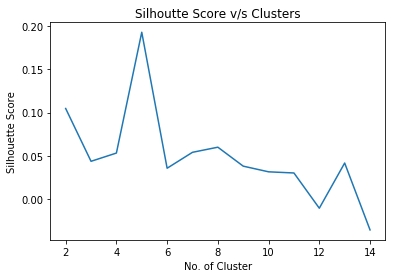

In [90]:
plt.plot(range(2, 15),sil_rating)
plt.xlabel('No. of Cluster')
plt.ylabel('Silhouette Score')
plt.title("Silhoutte Score v/s Clusters");

In [97]:
optimum_no_cluster=sil_rating.argmax()+2